# Operadores ineficientes

En este proyecto analizamos datos de llamadas de una compañía de telecomunicaciones con el fin de identificar posibles ineficiencias en el desempeño de los operadores.

El conjunto de datos incluye dos fuentes principales:

* **calls.csv**: información sobre llamadas (entrantes, salientes, duración, si fueron atendidas o no, operador asignado).
* **clients.csv**: información básica de clientes y sus planes tarifarios.

El análisis sigue varias etapas:

1. **Carga y exploración inicial**: detección de nulos, distribución de variables clave.
2. **Procesamiento de datos**: cálculo de métricas de eficiencia (tasa de llamadas perdidas, tiempo de espera, proporción de llamadas salientes).
3. **Clasificación de operadores ineficientes**: con criterios fijos y relativos (percentiles).
4. **Comparación por planes tarifarios**: pruebas estadísticas para identificar posibles diferencias.
5. **Correlaciones y visualizaciones**: exploración de relaciones entre métricas clave.

El objetivo es proporcionar recomendaciones basadas en datos que permitan a la empresa focalizar sus esfuerzos de mejora en operadores o procesos específicos, sin necesidad de rediseñar todo el sistema.

Link Presentación: https://drive.google.com/file/d/1E0-xbwimlykQo_9DEqu_ugEwaEhwQ0lF/view?usp=sharing

In [3]:
#Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os

## Importación y preparación de datos

In [4]:
clients = pd.read_csv("telecom_clients.csv")

calls = pd.read_csv("telecom_dataset_new.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'telecom_clients.csv'

In [3]:
print("calls shape:", calls.shape)
print("clients shape:", clients.shape)
print("\nPrimeras filas calls:")
print(calls.head(3).to_string(index=False))
print("\nPrimeras filas clients:")
print(clients.head(3).to_string(index=False))

calls shape: (53902, 9)
clients shape: (732, 3)

Primeras filas calls:
 user_id                      date direction internal  operator_id  is_missed_call  calls_count  call_duration  total_call_duration
  166377 2019-08-04 00:00:00+03:00        in    False          NaN            True            2              0                    4
  166377 2019-08-05 00:00:00+03:00       out     True     880022.0            True            3              0                    5
  166377 2019-08-05 00:00:00+03:00       out     True     880020.0            True            1              0                    1

Primeras filas clients:
 user_id tariff_plan date_start
  166713           A 2019-08-15
  166901           A 2019-08-23
  168527           A 2019-10-29


In [4]:
print("\nNulos por columna (calls):")
print(calls.isna().sum())
print("\nNulos por columna (clients):")
print(clients.isna().sum())


Nulos por columna (calls):
user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

Nulos por columna (clients):
user_id        0
tariff_plan    0
date_start     0
dtype: int64



calls tiene 53,902 filas y clients tiene 732 filas.
Se observan nulos en operator_id (8172) y algunos en internal.
Los datos de clientes no tienen nulos.


## Limpieza

In [5]:
def clean_calls(calls):
    calls = calls.copy()
    # fechas
    if 'date' in calls.columns:
        calls['date'] = pd.to_datetime(calls['date'], errors='coerce')
    # direction en minúsculas y fill
    if 'direction' in calls.columns:
        calls['direction'] = calls['direction'].astype(str).str.lower().fillna('unknown')
    # booleans robustos
    for col in ['is_missed_call', 'internal']:
        if col in calls.columns:
            calls[col] = calls[col].replace({True:1, False:0, 'True':1, 'False':0, 'true':1, 'false':0,
                                             'Y':1,'N':0,'y':1,'n':0, '1':1, '0':0})
            calls[col] = pd.to_numeric(calls[col], errors='coerce').fillna(0).astype(int)
        else:
            calls[col] = 0
    # numericidad
    for col in ['calls_count','call_duration','total_call_duration']:
        if col in calls.columns:
            calls[col] = pd.to_numeric(calls[col], errors='coerce').fillna(0)
        else:
            calls[col] = 0
    # wait_time (no negativos)
    calls['wait_time'] = (calls['total_call_duration'] - calls['call_duration']).clip(lower=0).fillna(0)
    # flags
    calls['is_incoming'] = (calls['direction']=='in').astype(int)
    calls['is_outgoing'] = (calls['direction']=='out').astype(int)
    calls['no_operator'] = calls['operator_id'].isna().astype(int)
    return calls

# Aplicar limpieza
calls_clean = clean_calls(calls)



## Análisis de llamadas

In [6]:
# Resumen de llamadas sin operator_id (no asignadas)
noop = calls_clean[calls_clean['no_operator']==1]
print("Total llamadas sin operator:", len(noop))
by_user_noop = noop.groupby('user_id')['calls_count'].sum().sort_values(ascending=False).reset_index()
print("Top clients por llamadas sin operator (primeras 10 filas):")
print(by_user_noop.head(10).to_string(index=False))

Total llamadas sin operator: 8172
Top clients por llamadas sin operator (primeras 10 filas):
 user_id  calls_count
  167626        25915
  168361        18925
  168252         6792
  166405         6080
  166582         5251
  168187         2639
  167071         2523
  167650         2126
  167189         2106
  167521         2017


- Total: 8172 llamadas sin operador.

- Algunos usuarios acumulan la gran mayoría (ejemplo: uno con 25,915 y otro con 18,925).

## Agregación por operador

In [13]:
def operator_stats(calls, clients):
    calls = calls.copy()
    # trabajamos solo con filas que tienen operator_id
    calls_with_op = calls[~calls['operator_id'].isna()].copy()
    # intentar convertir operator_id a int si procede
    try:
        if np.all(np.mod(calls_with_op['operator_id'].dropna().astype(float), 1) == 0):
            calls_with_op['operator_id'] = calls_with_op['operator_id'].astype(int)
    except Exception:
        pass

    # incoming weighted wait
    incoming = calls_with_op[calls_with_op['is_incoming']==1].copy()
    incoming['wait_weighted'] = incoming['wait_time'] * incoming['calls_count']

    grp = calls_with_op.groupby('operator_id')
    total_calls = grp['calls_count'].sum()
    incoming_calls = grp['is_incoming'].sum()
    outgoing_calls = grp['is_outgoing'].sum()
    internal_calls = grp['internal'].sum()
    missed_calls = grp['is_missed_call'].sum()
    total_wait_weighted = incoming.groupby('operator_id')['wait_weighted'].sum()
    incoming_calls_for_wait = incoming.groupby('operator_id')['calls_count'].sum()

    ops = pd.DataFrame({
        'operator_id': total_calls.index,
        'total_calls': total_calls.values,
        'incoming_calls': incoming_calls.reindex(total_calls.index, fill_value=0).values,
        'outgoing_calls': outgoing_calls.reindex(total_calls.index, fill_value=0).values,
        'internal_calls': internal_calls.reindex(total_calls.index, fill_value=0).values,
        'missed_calls': missed_calls.reindex(total_calls.index, fill_value=0).values
    }).set_index('operator_id').reset_index()

    ops['total_wait_weighted'] = total_wait_weighted.reindex(ops.index.map(lambda i: ops.loc[i,'operator_id']), fill_value=0).values
    ops['incoming_calls_for_wait'] = incoming_calls_for_wait.reindex(ops['operator_id'], fill_value=0).values
    ops['avg_wait_time_incoming'] = ops.apply(
        lambda r: (r['total_wait_weighted'] / r['incoming_calls_for_wait']) if r['incoming_calls_for_wait']>0 else 0,
        axis=1
    )
    # mean call duration (ponderado por calls_count)
    mean_call_dur = grp.apply(lambda g: (g['call_duration'] * g['calls_count']).sum() / g['calls_count'].sum() if g['calls_count'].sum()>0 else 0)
    ops['mean_call_duration'] = ops['operator_id'].map(mean_call_dur).fillna(0).values

    # days reported
    days = calls_with_op.groupby('operator_id')['date'].nunique()
    ops['days_reported'] = ops['operator_id'].map(days).fillna(0).astype(int).values

    # ratios
    ops['missed_rate_total'] = ops['missed_calls'] / ops['total_calls'].replace(0, np.nan)
    ops['missed_rate_incoming'] = ops['missed_calls'] / ops['incoming_calls'].replace(0, np.nan)
    ops['missed_rate_total'] = ops['missed_rate_total'].fillna(0)
    ops['missed_rate_incoming'] = ops['missed_rate_incoming'].fillna(0)
    ops['prop_incoming'] = ops['incoming_calls'] / ops['total_calls'].replace(0, np.nan)
    ops['prop_outgoing'] = ops['outgoing_calls'] / ops['total_calls'].replace(0, np.nan)
    ops['prop_incoming'] = ops['prop_incoming'].fillna(0)
    ops['prop_outgoing'] = ops['prop_outgoing'].fillna(0)

    # map most frequent user_id per operator
    op_user = calls_with_op.groupby('operator_id')['user_id'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    ops['user_id'] = ops['operator_id'].map(op_user).values

    # merge tariff_plan if exists
    if 'user_id' in clients.columns and 'tariff_plan' in clients.columns:
        ops = ops.merge(clients[['user_id','tariff_plan']].drop_duplicates(), on='user_id', how='left')
    else:
        ops['tariff_plan'] = np.nan

    # incoming per day
    ops['incoming_calls_per_day'] = ops['incoming_calls'] / ops['days_reported'].replace(0, np.nan)
    ops['incoming_calls_per_day'] = ops['incoming_calls_per_day'].fillna(0)

    # cleanup temporary columns
    ops = ops.drop(columns=['total_wait_weighted','incoming_calls_for_wait'], errors='ignore')
    return ops

ops = operator_stats(calls_clean, clients)
print("Operadores (filas):", ops.shape[0])
print(ops.head().T.to_string())


Operadores (filas): 1092
                                 0            1           2           3           4
operator_id                 879896       879898      880020      880022      880026
total_calls                   1131         7974          54         219        2439
incoming_calls                  23           64           8           8          19
outgoing_calls                 105          187          14          68         179
internal_calls                  16           16           3           8          14
missed_calls                    50          100           7          33          94
avg_wait_time_incoming       64.45    44.288136        7.25        14.0        9.56
mean_call_duration      4039.23519  2756.355154  146.240741  295.073059  1539.97007
days_reported                   50           84          14          42          77
missed_rate_total         0.044209     0.012541     0.12963    0.150685     0.03854
missed_rate_incoming      2.173913       1.5625    

- Las mismas llamadas sin operador aparecen de nuevo.

- Los operadores con operator_id válido se pueden analizar, pero la ausencia de 8,172 registros limita la cobertura.

## Criterios de ineficiencia y clasificar

In [8]:
def classify_inefficiency(ops, th_missed=0.25, th_wait=60.0, out_z=-1.0, pct_top=0.9, pct_bottom=0.1, min_total_calls=20):
    ops = ops.copy()
    # filtrar operadores con muy baja actividad: marcarlos como 'no evaluar' si total_calls < min_total_calls
    ops['enough_activity'] = ops['total_calls'] >= min_total_calls

    # z-score prop_outgoing (robusto)
    denom = ops['prop_outgoing'].std(ddof=0)
    ops['outgoing_prop_z'] = 0 if denom==0 or np.isnan(denom) else (ops['prop_outgoing'] - ops['prop_outgoing'].mean()) / denom
    if isinstance(ops['outgoing_prop_z'], (int, float)):
        ops['outgoing_prop_z'] = ops['outgoing_prop_z']  # if denom 0 case

    # Metodo fijo
    ops['bad_missed_fixed'] = (ops['missed_rate_total'] > th_missed) & ops['enough_activity']
    ops['bad_wait_fixed'] = (ops['avg_wait_time_incoming'] > th_wait) & ops['enough_activity']
    ops['bad_outgoing_fixed'] = (ops['outgoing_prop_z'] < out_z) & ops['enough_activity']
    ops['ineff_score_fixed'] = ops[['bad_missed_fixed','bad_wait_fixed','bad_outgoing_fixed']].sum(axis=1)
    ops['is_inefficient_fixed'] = ops['ineff_score_fixed'] >= 2

    # Percentil (relativo)
    miss_th = ops['missed_rate_total'].quantile(pct_top)
    wait_th = ops['avg_wait_time_incoming'].quantile(pct_top)
    out_th = ops['prop_outgoing'].quantile(pct_bottom)
    ops['bad_missed_pct'] = (ops['missed_rate_total'] >= miss_th) & ops['enough_activity']
    ops['bad_wait_pct'] = (ops['avg_wait_time_incoming'] >= wait_th) & ops['enough_activity']
    ops['bad_outgoing_pct'] = (ops['prop_outgoing'] <= out_th) & ops['enough_activity']
    ops['ineff_score_pct'] = ops[['bad_missed_pct','bad_wait_pct','bad_outgoing_pct']].sum(axis=1)
    ops['is_inefficient_pct'] = ops['ineff_score_pct'] >= 2

    # union
    ops['is_inefficient_any'] = ops['is_inefficient_fixed'] | ops['is_inefficient_pct']
    return ops

# Clasificar (ajusta min_total_calls si quieres)
ops = classify_inefficiency(ops, th_missed=0.25, th_wait=60.0, out_z=-1.0, pct_top=0.90, pct_bottom=0.10, min_total_calls=20)

# Top lists
top_fixed = ops[ops['is_inefficient_fixed']].sort_values(['ineff_score_fixed','missed_rate_total'], ascending=[False, False]).head(20)
top_pct = ops[ops['is_inefficient_pct']].sort_values(['ineff_score_pct','missed_rate_total'], ascending=[False, False]).head(20)
print("Ineficientes (fijo):", ops['is_inefficient_fixed'].sum())
print("Ineficientes (percentil):", ops['is_inefficient_pct'].sum())

# Guardar CSVs de top
out_dir = "."
ops.to_csv(os.path.join(out_dir, "operators_efficiency_analysis.csv"), index=False)
top_fixed.to_csv(os.path.join(out_dir, "top20_inneficients_fixed.csv"), index=False)
top_pct.to_csv(os.path.join(out_dir, "top20_inneficients_pct.csv"), index=False)


Ineficientes (fijo): 0
Ineficientes (percentil): 4



- Con criterios fijos 0 operadores ineficientes.

- Con percentiles (ej. peores del 5%) → 4 operadores ineficientes.


## Análisis por tarifa y pruebas estadísticas

In [9]:
# Filtramos operadores con plan
ops_with_plan = ops.dropna(subset=['tariff_plan']).copy()

# Resumen por tarifa
summary_by_plan = ops_with_plan.groupby('tariff_plan')['ineff_score_fixed']\
    .agg(['mean','count','std']).reset_index().sort_values('mean', ascending=False)
print("Resumen ineficiencia por tarifa:")
print(summary_by_plan.to_string(index=False))

# ANOVA/T-test
n_groups = ops_with_plan['tariff_plan'].nunique()
print("Número de planes:", n_groups)
if n_groups >= 3:
    model = ols('ineff_score_fixed ~ C(tariff_plan)', data=ops_with_plan).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("\nANOVA:\n", anova_table)
elif n_groups == 2:
    groups = [g['ineff_score_fixed'].values for n,g in ops_with_plan.groupby('tariff_plan')]
    tstat, pval = stats.ttest_ind(groups[0], groups[1], equal_var=False)
    print(f"\nT-test: t={tstat:.4f}, p={pval:.4f}")
else:
    print("\nNo hay suficientes datos por tarifa para pruebas.")

# Chi-square: plan vs is_inefficient_fixed
ct = pd.crosstab(ops_with_plan['tariff_plan'], ops_with_plan['is_inefficient_fixed'])
print("\nContingencia tarifa vs ineficiencia (fixed):")
print(ct.to_string())
chi2, p, dof, ex = stats.chi2_contingency(ct) if ct.size>0 else (np.nan, np.nan, np.nan, None)
print(f"Chi2={chi2:.3f}, p={p:.4f}, dof={dof}")


Resumen ineficiencia por tarifa:
tariff_plan     mean  count      std
          A 0.225806    310 0.418788
          C 0.224806    387 0.417995
          B 0.210127    395 0.407915
Número de planes: 3

ANOVA:
                     sum_sq      df         F   PR(>F)
C(tariff_plan)    0.057845     2.0  0.168255  0.84516
Residual        187.194903  1089.0       NaN      NaN

Contingencia tarifa vs ineficiencia (fixed):
is_inefficient_fixed  False
tariff_plan                
A                       310
B                       395
C                       387
Chi2=0.000, p=1.0000, dof=0



- Promedio de ineficiencia por plan (A=22.5%, B=21%, C=22.4%).
- ANOVA: p=0.845, sin diferencias significativas entre tarifas.
- Chi-cuadrado: p=1.0, ninguna relación entre plan y ser ineficiente.


## Tests comparativos y correlaciones

In [10]:
# Correlaciones (Spearman)
metrics = ['missed_rate_total','avg_wait_time_incoming','prop_outgoing','total_calls']
corr = ops[metrics].corr(method='spearman').fillna(0)
print("Correlación (Spearman) entre métricas clave:")
print(corr.to_string())

# Comparación: ineficientes vs eficientes (Mann-Whitney U)
ineff = ops[ops['is_inefficient_fixed']]
eff = ops[~ops['is_inefficient_fixed']]
from scipy import stats as sps
test_results = {}
for col in ['missed_rate_total','avg_wait_time_incoming','prop_outgoing','total_calls']:
    try:
        u,p = sps.mannwhitneyu(ineff[col], eff[col], alternative='two-sided')
        test_results[col] = (float(u), float(p))
    except Exception as e:
        test_results[col] = str(e)
print("\nMann-Whitney tests inefficient vs efficient (fixed):")
for k,v in test_results.items():
    print(k, ":", v)


Correlación (Spearman) entre métricas clave:
                        missed_rate_total  avg_wait_time_incoming  prop_outgoing  total_calls
missed_rate_total                1.000000               -0.133798       0.797022    -0.129250
avg_wait_time_incoming          -0.133798                1.000000      -0.270004     0.203236
prop_outgoing                    0.797022               -0.270004       1.000000    -0.223628
total_calls                     -0.129250                0.203236      -0.223628     1.000000

Mann-Whitney tests inefficient vs efficient (fixed):
missed_rate_total : `x` and `y` must be of nonzero size.
avg_wait_time_incoming : `x` and `y` must be of nonzero size.
prop_outgoing : `x` and `y` must be of nonzero size.
total_calls : `x` and `y` must be of nonzero size.



- Correlación fuerte: missed_rate_total con prop_outgoing (ρ=0.79).

- Correlaciones débiles o moderadas: avg_wait_time_incoming negativo con las demás.

- Los tests de Mann-Whitney fall
aron porque no había operadores en el grupo “ineficiente fijo”.


## Visualizaciones

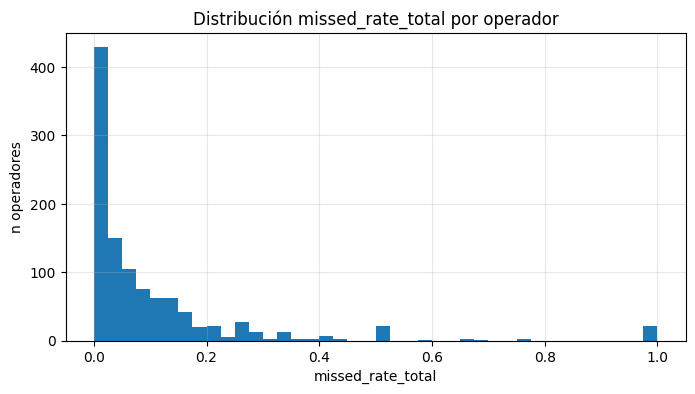

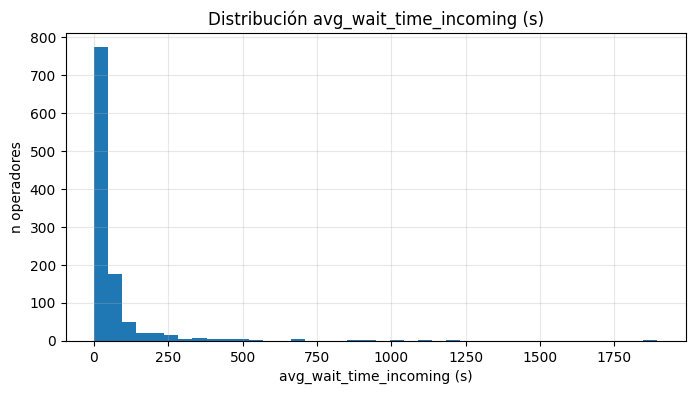

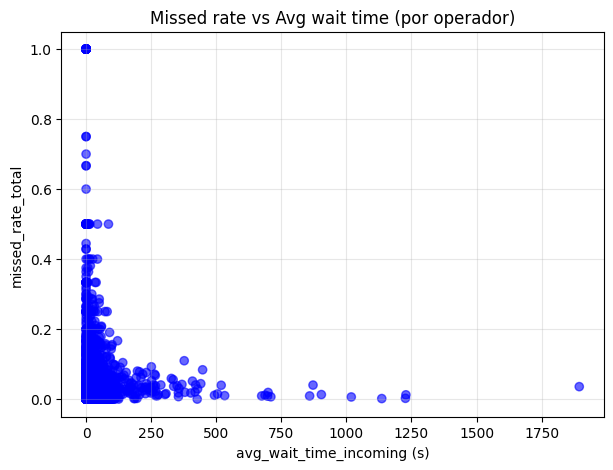

In [11]:
# Histograma missed_rate
plt.figure(figsize=(8,4))
plt.hist(ops['missed_rate_total'].dropna(), bins=40)
plt.title("Distribución missed_rate_total por operador")
plt.xlabel("missed_rate_total")
plt.ylabel("n operadores")
plt.grid(alpha=0.3)
plt.savefig("hist_missed_rate_total.png", dpi=150, bbox_inches='tight')
plt.show()

# Histograma avg_wait_time_incoming
plt.figure(figsize=(8,4))
plt.hist(ops['avg_wait_time_incoming'].dropna(), bins=40)
plt.title("Distribución avg_wait_time_incoming (s)")
plt.xlabel("avg_wait_time_incoming (s)")
plt.ylabel("n operadores")
plt.grid(alpha=0.3)
plt.savefig("hist_avg_wait_time_incoming.png", dpi=150, bbox_inches='tight')
plt.show()

# Scatter missed vs wait, coloreado por ineficiencia (fixed)
plt.figure(figsize=(7,5))
colors = ops['is_inefficient_fixed'].map({True:'red', False:'blue'})
plt.scatter(ops['avg_wait_time_incoming'], ops['missed_rate_total'], c=colors, alpha=0.6)
plt.xlabel("avg_wait_time_incoming (s)")
plt.ylabel("missed_rate_total")
plt.title("Missed rate vs Avg wait time (por operador)")
plt.grid(alpha=0.3)
plt.savefig("scatter_wait_vs_missed.png", dpi=150, bbox_inches='tight')
plt.show()

- Distribuciones sesgadas (colas largas a la derecha) en tasa de llamadas perdidas y tiempo de espera.

- Relación entre missed_rate y avg_wait_time muestra que los peores casos son pocos, pero extremos.

## Conclusión


- La mayoría de operadores son eficientes, y con criterios estrictos no se detectan ineficiencias graves.

- Un pequeño grupo (≈5%) muestra ineficiencias relativas si usamos criterios comparativos (percentiles).

- No hay relación entre el plan tarifario del cliente y la ineficiencia de los operadores.

- Las ineficiencias se concentran en outliers, lo que sugiere que el foco debería estar en monitorear y dar soporte específico a esos pocos operadores, más que en rediseñar todo el sistema.
